# Supplement B
# Drop Size Distribution retrieval


In the following, we introduce the use of the pyOptimalEstimation Python library using a radar-based drop-size distribution (DSD) retrieval as an example. 
Williams et al. (2014) suggested to parameterize a DSD using a scaling parameter $N_w$ as well as the raindrop mass spectrum mean diameter $D_m$ and its standard deviation $\sigma_m$.
Assuming that the DSD follows a gamma distribution, $\sigma_m$ is related to the shape parameter $\mu$ with 
\begin{equation} 
    \mu = (D_m/\sigma)^2 -4
\end{equation}
and we reconstruct the original DSD $N(D)$ as a function of maximum dimension $D$ with
\begin{equation}
    N(D) = N_w \frac{6}{256} \frac{(4+\mu)^{\mu+4}}{\Gamma(\mu+4)} \Big(\frac{D}{D_m}\Big)^{\mu} \exp \Big[ -(4+\mu) \frac{D}{D_m}\Big]
\end{equation}
using the normalization approach by Testud et al. (2001).

Williams et al. (2014) analyzed the correlations between $D_m$ and $\sigma_m$ in  detail and proposed to use a modified quantity $\sigma_m\!'$ defined with 
\begin{equation}
    \sigma_m\!' = \sigma_m D_m^{-1.36}
\end{equation}
in order to minimize the correlation to $D_m$. The three parameters required to estimate the DSD ($N_w$, $D_m$, and $\sigma_m\!'$) will form our state vector $\mathbf{x}$. 


A radar simulator will use $\mathbf{x}$ to estimate the measurement vector $\mathbf{y}$ consisting of the radar reflectivity factor ($Z_e$ in dBz) and the mean Doppler velocity ($V_d$ in m s$^{-1}$) with 
    \begin{equation}
    Z_e = 10 \times \log_{10} (10^{18} \times \sum_i N(D_i) \times \frac{\lambda^4}{|K_w|^2 \pi^5} \times \sigma(D_i) \times \Delta D ) 
    \end{equation}  
and
        \begin{equation}
V_d = \frac{\sum_i v(D_i) \times N(D_i) \times  \sigma(D_i) \times \Delta D}{\sum_i N(D_i) \times  \sigma(D_i) \times \Delta D}
    \end{equation}
where $i$ the index of the discrete DSD and $\sigma$ and $v$ are the functions to describe backscattering cross section and fall velocity, respectively. This means we have two measurements to derive three quantities of the state space, i.e. the problem is not unambiguous. 
In order to obtain the required prior data set, we use the Huntsville data set introduced in Williams et al. (2014) which consists of 18969 individual DSD distributions obtained at Huntsville, AL from December 2009 to October 2011. For every DSD, Williams et al. (2014) determined $N_w$, $D_m$, and $\sigma_m$ and we determine the a-priori assumption $\mathbf{x}_a$ and uncertainty (**S**$_a$) form the mean and the covariance of the data set, respectively. 

# Installation 
**You can skip the installation if you execute this online on binder**

In order to design a retrieval with pyOptimalEstimation, we need to install the library first with 
~~~~  
pip install pyOptimalEstimation
~~~~ 
for Python 2.7 or Python 3. This example uses Python 3.6. It requires the numpy, scipy, pandas and matplotlib libraries to be installed, this example makes use also of the xarray, seaborn, uncertainties, and xarray libraries. For development, we used Numpy 1.18.1, Matplotlib 3.0.3, Scipy 1.2.1, Xarray 0.15.1, Pandas 1.0.3, Seaborn 0.9.0 and Uncertainties 3.0.3.

The radar simulations are done with the Passive and Active Microwave radiative TRAnsfer model (PAMTRA, Mech et al. 2020). Here, we use version 2 that is in active development, so we install a specific version with:
~~~~ 
pip install git+git://github.com/maahn/pamtra2.git@461b711ae366b791665687de5dec37abd7ab78f5
~~~~ 

# Preparation

We start with loading the required libraries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pn
import xarray as xr
import uncertainties.unumpy as unp
import seaborn as sns

import pamtra2

import pyOptimalEstimation as pyOE

%matplotlib inline
sns.set(style='ticks', palette='deep')
abc = 'abcdefghijklmopqrstuvwxyz'

/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/abc.py:133: FutureWarning: xarray subclass customProfile should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)


We put some helper routines in a separate file which we load with 

In [2]:
import sys
sys.path.append('lib')
import supporting_routines

## State vector

In order to load the required prior data set, we load the Huntsville data set of Williams et al. (2014) from a netCDF file using xarray:

In [3]:
rainDat = xr.open_dataset('data/huntsville_parameters.nc')[[
    'Dm', 'Nw', 'Smprime'
]]

and add logarithmic variables with

In [4]:
rainDat['Nw_log10'] = np.log10(rainDat['Nw'])
rainDat['Dm_log10'] = np.log10(rainDat['Dm'])
rainDat['Smprime_log10'] = np.log10(rainDat['Smprime'])

rainDat

<xarray.Dataset>
Dimensions:        (time: 18969)
Coordinates:
  * time           (time) datetime64[ns] 2009-12-13T04:24:00 ... 2011-04-04T21:51:00
Data variables:
    Dm             (time) float64 1.117 1.003 1.014 1.112 ... 1.377 1.475 1.476
    Nw             (time) float64 2.328e+03 4.55e+03 ... 3.125e+03 1.156e+03
    Smprime        (time) float64 0.3058 0.2524 0.2513 ... 0.3837 0.3386 0.3318
    Nw_log10       (time) float64 3.367 3.658 4.037 3.925 ... 3.581 3.495 3.063
    Dm_log10       (time) float64 0.04817 0.001143 0.00605 ... 0.1689 0.1692
    Smprime_log10  (time) float64 -0.5145 -0.598 -0.5999 ... -0.4703 -0.4791

We use 100 randomly chosen DSDs for the test data set and use the remaining DSDs for the training data set, i.e. to develop the retrieval.

In [5]:
nTest = 100

np.random.seed(10)
ii = np.arange(len(rainDat.time))
np.random.shuffle(ii)
testII, trainingII = ii[:nTest], ii[nTest:]

rainDat_test = rainDat.isel(time=testII)
rainDat_training = rainDat.isel(time=trainingII)

In order to asses the assumptions that the state variables follow a Gaussian distribution, we make quantile-quantile (QQ) plots. Comparison of the first and second column reveals that a logarithmic state vector $\mathbf{x}$ is much closer to a Gaussian distribution than the linear version. 

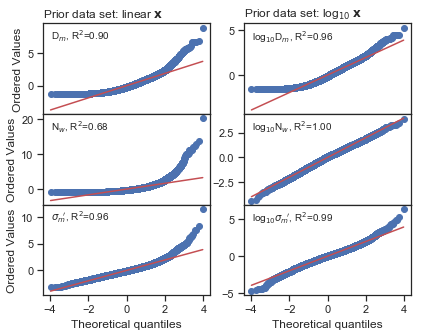

In [6]:
ncols = 2
fig, sps = plt.subplots(figsize=(6.6, 5), nrows=3, ncols=ncols, sharex=True)

sps = sps.reshape((3, ncols))

jj = 0

for kk in range(3):
    for ii, (x_name, x_vars) in enumerate([
        ('linear', ['Dm', 'Nw', 'Smprime']),
        ('log$_{10}$', ['Dm_log10', 'Nw_log10', 'Smprime_log10']),
    ]):

        x_var = x_vars[kk]
        data = (rainDat_training[x_var] - np.mean(
            rainDat_training[x_var])) / np.std(rainDat_training[x_var])
        (osm, osr), (slope, intercept, r) = stats.probplot(
            data, dist="norm", plot=sps[kk, ii], fit=True, rvalue=False)

        sps[kk, ii].set_title('')
        if kk == 0:
            sps[kk, ii].set_title(
                'Prior data set: %s $\mathbf{x}$' % (x_name),
                loc='left')

        sps[kk, ii].text(
            0.05,
            0.95,
            '%s, R$^2$=%.2f' % (
                supporting_routines.niceKeys[x_var], r**2
                #, x_mean, x_std
            ),
            horizontalalignment='left',
            verticalalignment='top',
            transform=sps[kk, ii].transAxes)

        if kk < 2:
            sps[kk, ii].set_xlabel("")
        if ii > 0:
            sps[kk, ii].set_ylabel("")
        jj += 1

fig.subplots_adjust(hspace=0)

The prior $\mathbf{x}_{a}$ and covariance **S**$_a$ of the state vector are estimated from the training data set. For convenience, we estimate it for the linear and logarithmic variables together and select the required quantities later. 

Dm                  1.461640
Nw               4054.575495
Smprime             0.299574
Nw_log10            3.436274
Dm_log10            0.153298
Smprime_log10      -0.530466
dtype: float64


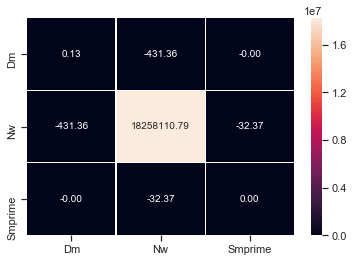

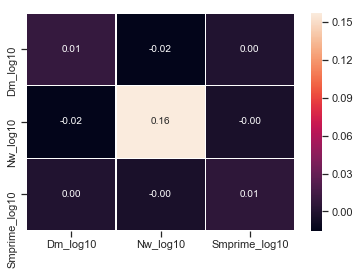

In [7]:
S_a = rainDat_training.to_dataframe().cov()
x_ap = rainDat_training.to_dataframe().mean()
print(x_ap)

plt.figure()
sns.heatmap(
    S_a[
        ['Dm', 'Nw', 'Smprime']
    ].loc[
        ['Dm', 'Nw', 'Smprime']
    ],
    annot=True,
    fmt='.2f',
    linewidths=.05)

plt.figure()
sns.heatmap(
    S_a[
        ['Dm_log10', 'Nw_log10', 'Smprime_log10']
    ].loc[
        ['Dm_log10', 'Nw_log10', 'Smprime_log10']
    ],
    annot=True,
    fmt='.2f',
    linewidths=.05)

When estimating the prior, the use of SI units is not always recommended: Combining small and large quantities with different units (e.g. temperature in K and specific humidity in kg/kg), the prior can be singular prohibiting an efficient use. 

## Measurement space

The measurement vector $\mathbf{y}$ consists of the radar reflectivity factor ($Z$) and the mean Doppler velocity ($V_d$) at 13.6 GHz and 35.5 GHz. Even though we use only 13.6 GHz in the following, we encourage the reader to experiment with different $\mathbf{y}$ combinations. For  **S**$_y$, we assume that the uncertainties of  $Z$ and $V_d$ are 1 dB and 0.3 m s$^{-1}$, respectively, and that the errors are not correlated. Even though these error estimates are generally realistic, the values should be carefully evaluated for a real world application.

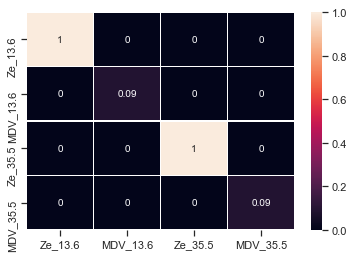

In [8]:
y_vars = ["Ze_13.6", "MDV_13.6", "Ze_35.5", "MDV_35.5"]
y_noise = np.array([1, .3, 1, .3])
S_y = pn.DataFrame(
    np.diag(y_noise**2),
    index=y_vars,
    columns=y_vars,
)
sns.heatmap(S_y, annot=True, fmt='g', linewidths=.05)

## Forward operator
To prepare the retrieval, we set up PAMTRA2 properly and create dictionaries to store the results.

In [9]:
pam2Prepared = supporting_routines.preparePamtra(frequencies=[13.6e9, 35.5e9])


Did not find information about relativePermittivityIce. This might cause trouble later.


/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/pamtra2-0.1-py3.6-macosx-10.7-x86_64.egg/pamtra2/libs/singleScattering/scattering_utilities.py:170: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.arccos((cos_sca-cos_th*cos_inc)/(sin_th*sin_inc))
/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/pamtra2-0.1-py3.6-macosx-10.7-x86_64.egg/pamtra2/libs/singleScattering/scattering_utilities.py:171: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.arccos((cos_inc-cos_th*cos_sca)/(sin_th*sin_sca))


The message about `relativePermittivityIce` can be ignored. After this, the forward operator can be run with `supporting_routines.forwardPamtra`.  In short, the forward operator accepts $\mathbf{x}$ as an input argument and returns $\mathbf{y}$. In addition, `pam2Prepared` (prepared above) and the list of $\mathbf{y}$ elements to be returned needs to be provided. See `libs/supporting_routines.py` for details.

# Example retrieval

First, we need names for the elements of $\mathbf{x}$  and $\mathbf{y}$ 

In [10]:
x_vars = ['Dm', 'Nw', 'Smprime']
y_vars = ["Ze_13.6", "MDV_13.6"]

Additional  variables required for the forward operator

In [11]:
forwardKwArgs = {'pam2': pam2Prepared, 'y_vars': y_vars}

We use the 51st profile from the test data set as $\mathbf{x}_{truth}$

In [12]:
tt = 51
x_truth = rainDat_test[x_vars].to_dataframe().iloc[tt]

For simplicity, we use synthetic observations, i.e. we use PAMTRA2 to simulate an observation based on a known atmospheric state $\mathbf{x}_{truth}$. Even though $\mathbf{x}_{truth}$ is typically unknown in a real-world example, the use of synthetic observations is extremely helpful for assessing retrieval performance by comparing $\mathbf{x}_{op}$ to $\mathbf{x}_{truth}$. The `**forwardKwArgs` passes all dictionary values of `forwardKwArgs` as named function arguments (see https://www.geeksforgeeks.org/args-kwargs-python/).

In [13]:
y_obs = supporting_routines.forwardPamtra(
    x_truth,
    **forwardKwArgs,
)
y_obs

Ze_13.6     29.756770
MDV_13.6     6.194538
dtype: float64

`pyOptimalEstimation` uses objects. Therefore, we combine all information for the reference run into an object which we name `oe` 

In [14]:
# create optimal estimation object
oe = pyOE.optimalEstimation(
    x_vars,  # state variable names
    x_ap[x_vars],  # a priori
    S_a[x_vars].loc[x_vars],  # a priori uncertainty
    y_vars,  # measurement variable names
    y_obs,  # observations
    S_y[y_vars].loc[y_vars],  # observation uncertainty
    supporting_routines.forwardPamtra,  # forward Operator
    forwardKwArgs=forwardKwArgs,  # additonal function arguments
)

We store the true profile in the `oe` object. This is just for convenience, it is not
used by the retrieval.

In [15]:
oe.x_truth = x_truth

We run the retrieval with max. 10 iterations.

In [16]:
converged = oe.doRetrieval(maxIter=10)

0.48 s, iteration 1, degrees of freedom: 1.92 of 3, not converged (x-space):  1.375
0.73 s, iteration 2, degrees of freedom: 1.91 of 3, converged (x-space):  0.001
0.98 s, iteration 3, degrees of freedom: 1.91 of 3, done.  0.000


It converges after 2 iterations. 1.91 degrees of freedom for signal $d$ (the number of independent information pieces) are retrieved which is shows the good performance of the retrieval given that the maximum $d$ value is 2 because $\mathbf{y}$ consists of 2 measurements. 

After convergence, the solution $\mathbf{x}_{op}$ and the retrieved uncertainty **S**$_{op}$ is available with

In [17]:
print(oe.x_op)
print(oe.S_op)

Dm            1.444864
Nw         2102.003124
Smprime       0.306848
dtype: float64
                 Dm            Nw    Smprime
Dm         0.016757 -1.698757e+02  -0.004985
Nw      -169.875723  2.066878e+06  42.193265
Smprime   -0.004985  4.219327e+01   0.002522


pyOptimalEstimation uses Pandas objects not only for the input, but also for the output to make sure the elements of $\mathbf{x}$ and $\mathbf{y}$ are not mixed up.

For convenience, the 1 $\sigma$ uncertainties derived from **S**$_{op}$ are also available

In [18]:
print(oe.x_op_err)

Dm            0.129451
Nw         1437.664246
Smprime       0.050219
dtype: float64


$d$ is available as a total as well as per $\mathbf{x}$ variable

In [19]:
print('total', oe.dgf)
print(oe.dgf_x)

total 1.9093322923665519
Dm         0.904881
Nw         0.881159
Smprime    0.123292
dtype: float64


We recommend to apply various statistical tests to the result with the `chiSquareTest()` function. The tests include:

1. $\mathbf{y}_{op}$  agrees with the measurement $\mathbf{y}_{obs}$ (`Y_Optimal_vs_Observation`, Rodgers, 2000, Sec. 12.3.2) 
2. the observation $\mathbf{y}_{obs}$ agrees with the prior **S**$_a$ (`Y_Observation_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.1) 
3. the retrieved measurement agrees with the prior **S**$_a$ (`Y_Optimal_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.3) 
4. the retrieved state $\mathbf{x}_{op}$ agrees with the prior **S**$_a$ (`X_Optimal_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.2) 



In [20]:
print(oe.chiSquareTest()[0])

Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


Finally, we test with `testLinearity()`  whether the forward operator is moderately linear following chapter 5.1 of Rodgers 2000. The analysis for this example is based on $\mathbf{x}_{truth}$. The $\chi^2$ value (`trueLinearityChi2`) corresponding to the model beeing moderately linear must be smaller than the critical value (`trueLinearityChi2Crit`).

The first returned element is a boolean indicating whether the $\chi^2$ tests were successful: 

In [21]:
linearity, trueLinearityChi2, trueLinearityChi2Crit = oe.linearityTest(
    significance=0.05)
print('Linearity test passed: ', trueLinearityChi2 < trueLinearityChi2Crit)

Linearity test passed:  False


The fact that this test fails indicates already that the retrieval with linear $\mathbf{x}$ variables does not work properly (see below).

When running several retrievals, we recommend using the `oe.summarize` function which summarizes all retrieval results in an Xarray Dataset (which is structured similar to a netCDF file):

In [22]:
oe.summarize(returnXarray=True)

<xarray.Dataset>
Dimensions:                    (chi2test: 4, x_vars: 3, x_vars_T: 3, y_vars: 2, y_vars_T: 2)
Coordinates:
  * x_vars                     (x_vars) object 'Dm' 'Nw' 'Smprime'
  * x_vars_T                   (x_vars_T) object 'Dm' 'Nw' 'Smprime'
  * y_vars                     (y_vars) object 'Ze_13.6' 'MDV_13.6'
  * y_vars_T                   (y_vars_T) object 'Ze_13.6' 'MDV_13.6'
  * chi2test                   (chi2test) object 'Y_Optimal_vs_Observation' ... 'X_Optimal_vs_Prior'
Data variables:
    x_a                        (x_vars) float64 1.462 4.055e+03 0.2996
    x_a_err                    (x_vars) float64 0.3585 4.273e+03 0.05471
    S_a                        (x_vars, x_vars_T) float64 0.1285 ... 0.002993
    x_op                       (x_vars) float64 1.445 2.102e+03 0.3068
    x_op_err                   (x_vars) float64 0.1295 1.438e+03 0.05022
    S_op                       (x_vars, x_vars_T) float64 0.01676 ... 0.002522
    dgf_x                      (x_vars) float64 0.9049 0.8812 0.1233
    y_obs                      (y_vars) float64 29.76 6.195
    S_y                        (y_vars, y_vars_T) float64 1.0 0.0 0.0 0.09
    y_op                       (y_vars) float64 29.82 6.17
    x_truth                    (x_vars) float64 1.202 5.823e+03 0.4368
    trueLinearityChi2          float64 10.53
    trueLinearityChi2Critical  float64 5.991
    chi2value                  (chi2test) float64 0.2741 0.1652 0.1614 0.2572
    chi2critical               (chi2test) float64 5.991 5.991 5.991 5.991
    dgf                        float64 1.909
    convergedIteration         int64 3

# Run retrieval

After we presented the retrieval step-by-step, we integrate everything into a loop to apply the retrieval to all 100 profiles. 

The results are saved in dictionaries:

In [23]:
resultsOE = {}
failed = {}

To compare performance, we run the retrieval in two configurations:

1. linear state variables (see the step-by-step example above)
2. logarithmic state variables


In [24]:
#     name, [X_variables],
x_names = dict([
    ('Linear', ['Dm', 'Nw', 'Smprime']),
    ('log$_{10}$', ['Dm_log10', 'Nw_log10', 'Smprime_log10']),
])

In this study, we use only a measurement configuration consisting of a radar reflectivity ($Z_e$ in dBz) and the mean Doppler velocity ($V_d$ in m s$^{-1}$). But the example is designed to work also with dual-frequency set ups and we encourage the reader to experiment  with different configurations. 


In [25]:
#     name, [Y_variables],
y_names = dict([
    ('Z', ["Ze_13.6"]),
    ('ZW', ["Ze_13.6", "MDV_13.6"]),
    ('Zdual', ["Ze_13.6", "Ze_35.5"]),
    ('ZWdual', ["Ze_13.6", "MDV_13.6", "Ze_35.5", "MDV_35.5"]),
])

In [26]:
%%time
for x_name, y_name in (
    (
        'Linear',
        'ZW',
    ),
    ('log$_{10}$', 'ZW'),
):

    x_vars = x_names[x_name]
    y_vars = y_names[y_name]

    resultsOE['%s %s' % (x_name, y_name)] = []
    failed['%s %s' % (x_name, y_name)] = []

    #Additional required variables for the forward operator
    forwardKwArgs = {'pam2': pam2Prepared, 'y_vars': y_vars}

    print('#' * 80)
    print(x_name, y_name)
    print('#' * 80)
 
    #     for tt in [15, 20, 51]:
    for tt in range(rainDat_test[x_vars].time.shape[0]):

        x_truth = rainDat_test[x_vars].to_dataframe().iloc[tt]
        # simulate observation based on true state x_truth
        y_obs = supporting_routines.forwardPamtra(
            x_truth,
            pam2=pam2Prepared,
            y_vars=y_vars,
        )

        # create optimal estimation object
        oe = pyOE.optimalEstimation(
            x_vars,  # state variable names
            x_ap[x_vars],  # a priori
            S_a[x_vars].loc[x_vars],  # a priori uncertainty
            y_vars,  # measurement variable names
            y_obs,  # observations
            S_y[y_vars].loc[y_vars],  # observation uncertainty
            supporting_routines.forwardPamtra,  # forward Operator
            forwardKwArgs=forwardKwArgs,  # additonal function arguments
        )

        # Store true profile in `oe` object. This is just for convenience, it is not
        # used by the retrieval.
        oe.x_truth = x_truth

        # Do the retrieval with max. 10 iterations.
        converged = oe.doRetrieval(maxIter=10)

        if converged:

            # Test whethe rthe retrieval is moderately lienar around x_truth
            print(oe.linearityTest())

            # Show hdegrees of freedom per variable
            print(oe.dgf_x)

            # Apply chi2 tests for retrieval quality
            print(oe.chiSquareTest())

            if x_name.startswith('log'):
                # Show RMS normalized with prior
                print(
                    'RMS log',
                    np.sqrt(
                        np.mean(
                            ((10**oe.x_truth - 10**oe.x_op) / 10**oe.x_a)**2)))
                print('truth', 10**oe.x_truth)
                print('op', 10**unp.uarray(oe.x_op.values, oe.x_op_err.values))
            else:
                # Show RMS normalized with prior
                print('RMS',
                      np.sqrt(np.mean(((oe.x_truth - oe.x_op) / oe.x_a)**2)))
                print('truth', oe.x_truth)
                print('op', unp.uarray(oe.x_op.values, oe.x_op_err.values))

            #Store results in xarray DataArray
            summary = oe.summarize(returnXarray=True)
            summary['time'] = rainDat_test[x_vars].time[tt]

            resultsOE['%s %s' % (x_name, y_name)].append(summary)
        else:
            failed['%s %s' % (x_name, y_name)].append(tt)

    #Store results in xarray Dataset structure for later analysis.
    resultsOE['%s %s' % (x_name, y_name)] = xr.concat(
        resultsOE['%s %s' % (x_name, y_name)], dim='time')

################################################################################
Linear ZW
################################################################################
0.65 s, iteration 1, degrees of freedom: 1.77 of 3, converged (x-space):  0.017
0.83 s, iteration 2, degrees of freedom: 1.77 of 3, done.  0.000
([1.31664499661615, 0.00067507598515647, 0.0005244346764850746], array(0.06722079), 5.991464547107983)
Dm         0.967234
Nw         0.610596
Smprime    0.196107
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.170134
Y_Observation_vs_Prior      0.163760
Y_Optimal_vs_Prior          0.166656
X_Optimal_vs_Prior          0.161910
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prio

0.49 s, iteration 1, degrees of freedom: 1.94 of 3, not converged (x-space):  3.753
0.71 s, iteration 2, degrees of freedom: 1.92 of 3, converged (x-space):  0.001
0.94 s, iteration 3, degrees of freedom: 1.92 of 3, done.  0.000
([6.796875046063077, 0.0013430031961420253, 0.0001778116391400857], array(0.04821977), 5.991464547107983)
Dm         0.902085
Nw         0.908848
Smprime    0.111050
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.439910
Y_Observation_vs_Prior      0.208485
Y_Optimal_vs_Prior          0.204488
X_Optimal_vs_Prior          0.364131
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.99

/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/xarray/core/computation.py:604: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 1
0.42 s, iteration 1, degrees of freedom: 0.96 of 3, not converged (x-space):  15.879
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 2
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 2
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 2
0.61 s, iteration 2, degrees of freedom: 0.00 of 3.degrees of freedom 0! STOP  0.000
0.43 s, iteration 1, degrees of freedom: 1.59 of 3, not converged (x-space):  1.320
0.62 s, iteration 2, d

Name: chi2critical, dtype: float64)
RMS 0.5378691984337596
truth Dm             1.121804
Nw         11620.533963
Smprime        0.246010
Name: 2010-01-17 04:45:00, dtype: float64
op [1.1700848155765788+/-0.07449712350016437
 7852.348482647145+/-3262.399455038073
 0.26268180609243563+/-0.04742708181158568]
0.42 s, iteration 1, degrees of freedom: 1.87 of 3, not converged (x-space):  6.807
0.60 s, iteration 2, degrees of freedom: 1.83 of 3, converged (x-space):  0.002
0.78 s, iteration 3, degrees of freedom: 1.83 of 3, done.  0.000
([11.011645246492812, 0.0018506870972420323, 0.000455339466880383], array(0.13838729), 5.991464547107983)
Dm         0.775671
Nw         0.890580
Smprime    0.167049
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation  

1.88 s, iteration 3, degrees of freedom: 1.58 of 3, done.  0.000
([0.41728084367070545, 0.0021004997596182386, 0.00040872328086154187], array(0.01534852), 5.991464547107983)
Dm         0.999688
Nw         0.385206
Smprime    0.192780
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.987335
Y_Observation_vs_Prior      3.050674
Y_Optimal_vs_Prior          4.150949
X_Optimal_vs_Prior          1.984723
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 0.13822851034751177
truth Dm            1.128406
Nw         8012.744559
Smprime       0.208734
Name: 2011-07-30 16:0

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 1
0.70 s, iteration 1, degrees of freedom: 0.95 of 3, not converged (x-space):  1.963
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 2
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 2
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 2
1.06 s, iteration 2, degrees of freedom: 0.00 of 3.degrees of freedom 0! STOP  0.000
0.79 s, iteration 1, degrees of freedom: 1.59 of 3, not converged (x-space):  1.285
1.15 s, iteration 2, de

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 1
0.72 s, iteration 1, degrees of freedom: 0.95 of 3, not converged (x-space):  4.006
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 2
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 2
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 2
1.09 s, iteration 2, degrees of freedom: 0.00 of 3.degrees of freedom 0! STOP  0.000
0.67 s, iteration 1, degrees of freedom: 1.56 of 3, not converged (x-space):  2.052
0.97 s, iteration 2, de

0.62 s, iteration 1, degrees of freedom: 1.80 of 3, not converged (x-space):  1.543
0.91 s, iteration 2, degrees of freedom: 1.78 of 3, converged (x-space):  0.000
1.22 s, iteration 3, degrees of freedom: 1.78 of 3, done.  0.000
([2.048844201113544, 0.0016813140207033572, 0.00030469835177503895], array(0.00026284), 5.991464547107983)
Dm         0.980263
Nw         0.674530
Smprime    0.121112
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.454145
Y_Observation_vs_Prior      1.249811
Y_Optimal_vs_Prior          1.274985
X_Optimal_vs_Prior          1.417232
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.9

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 1
1.30 s, iteration 1, degrees of freedom: 0.94 of 3, not converged (x-space):  5.277
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 2
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 2
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 2
1.91 s, iteration 2, degrees of freedom: 0.00 of 3.degrees of freedom 0! STOP  0.000
1.08 s, iteration 1, degrees of freedom: 1.91 of 3, not converged (x-space):  5.650
1.36 s, iteration 2, de

0.94 s, iteration 1, degrees of freedom: 1.82 of 3, converged (x-space):  0.001
1.28 s, iteration 2, degrees of freedom: 1.82 of 3, done.  0.000
([1.9368067416987396, 0.0011338660959801126, 0.0002582096595542631], array(2.4631753e-06), 5.991464547107983)
Dm         0.949024
Nw         0.681695
Smprime    0.185024
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.023930
Y_Observation_vs_Prior      0.023478
Y_Optimal_vs_Prior          0.023470
X_Optimal_vs_Prior          0.023613
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 0.007410190958137247
truth Dm      

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 2
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 2
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 2
1.69 s, iteration 2, degrees of freedom: 0.00 of 3.degrees of freedom 0! STOP  0.000
0.99 s, iteration 1, degrees of freedom: 1.86 of 3, converged (x-space):  0.262
1.39 s, iteration 2, degrees of freedom: 1.86 of 3, done.  0.000
([2.8890138814170925, 0.0005926254389196145, 0.0005138074116814075], array(0.46761068), 5.991464547107983)
Dm         0.951460
Nw         0.777569
Smprime    0.130092
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior      

1.05 s, iteration 2, degrees of freedom: 1.92 of 3, converged (x-space):  0.005
1.45 s, iteration 3, degrees of freedom: 1.91 of 3, done.  0.000
([6.74573075331387, 0.0014702957457008285, 0.00043647928228177286], array(1.21411069e-05), 5.991464547107983)
Dm         0.946828
Nw         0.902556
Smprime    0.065504
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    2.124928
Y_Observation_vs_Prior      1.363089
Y_Optimal_vs_Prior          1.363218
X_Optimal_vs_Prior          1.743527
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 0.0054072953261319785
truth Dm     

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 2
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 2
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 2
1.15 s, iteration 2, degrees of freedom: 0.00 of 3.degrees of freedom 0! STOP  0.000
0.88 s, iteration 1, degrees of freedom: 1.95 of 3, not converged (x-space):  49.904
1.24 s, iteration 2, degrees of freedom: 1.94 of 3, not converged (x-space):  0.765
1.59 s, iteration 3, degrees of freedom: 1.93 of 3, converged (x-space):  0.003
2.19 s, iteration 4, degrees of freedom: 1.93 of 3, done.  0.000
([11.898817742270491, 0.0018447019099099892, 4.699817050723085e-05], array(2.67587646), 5.991464547107983)
Dm         0.869466
Nw         0.950281
Smprime    0.111915
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This 

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 1
0.63 s, iteration 1, degrees of freedom: 0.96 of 3, not converged (x-space):  25.315
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 2
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 2
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 2
0.95 s, iteration 2, degrees of freedom: 0.00 of 3.degrees of freedom 0! STOP  0.000
0.99 s, iteration 1, degrees of freedom: 1.89 of 3, not converged (x-space):  3.951
1.48 s, iteration 2, d

0.70 s, iteration 1, degrees of freedom: 1.82 of 3, converged (x-space):  0.003
1.06 s, iteration 2, degrees of freedom: 1.82 of 3, done.  0.000
([1.9848280577538169, 0.0010109095175106207, 0.0003192752786278283], array(0.03702267), 5.991464547107983)
Dm         0.950648
Nw         0.690578
Smprime    0.178647
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.055638
Y_Observation_vs_Prior      0.053258
Y_Optimal_vs_Prior          0.053227
X_Optimal_vs_Prior          0.053968
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 0.20300605692078597
truth Dm          

0.78 s, iteration 1, degrees of freedom: 1.78 of 3, converged (x-space):  0.007
1.59 s, iteration 2, degrees of freedom: 1.77 of 3, done.  0.000
([0.010245929625697519, 0.00042280090111840773, 0.00017657269207544234], array(0.00199259), 5.991464547107983)
Dm_log10         0.952250
Nw_log10         0.656234
Smprime_log10    0.166329
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.169331
Y_Observation_vs_Prior      0.176418
Y_Optimal_vs_Prior          0.177609
X_Optimal_vs_Prior          0.167549
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.3029503106

0.57 s, iteration 1, degrees of freedom: 1.72 of 3, not converged (x-space):  0.630
0.82 s, iteration 2, degrees of freedom: 1.71 of 3, converged (x-space):  0.000
1.06 s, iteration 3, degrees of freedom: 1.71 of 3, done.  0.000
([0.009531984358981373, 0.000136029902042968, 6.648974329959327e-05], array(0.08325564), 5.991464547107983)
Dm_log10         0.948767
Nw_log10         0.641796
Smprime_log10    0.123012
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    3.970047
Y_Observation_vs_Prior      4.242244
Y_Optimal_vs_Prior          4.243530
X_Optimal_vs_Prior          3.969280
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs

0.57 s, iteration 1, degrees of freedom: 1.76 of 3, converged (x-space):  0.047
0.82 s, iteration 2, degrees of freedom: 1.76 of 3, done.  0.000
([0.011578622544570883, 0.0002559226375298337, 0.00017910644272481346], array(0.00697838), 5.991464547107983)
Dm_log10         0.953780
Nw_log10         0.661391
Smprime_log10    0.145042
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.744942
Y_Observation_vs_Prior      0.817763
Y_Optimal_vs_Prior          0.836246
X_Optimal_vs_Prior          0.742361
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.83253289738

0.57 s, iteration 1, degrees of freedom: 1.73 of 3, not converged (x-space):  0.349
0.82 s, iteration 2, degrees of freedom: 1.73 of 3, converged (x-space):  0.000
1.07 s, iteration 3, degrees of freedom: 1.73 of 3, done.  0.000
([0.010771932552596624, 0.00014170301828832278, 9.875261461971162e-05], array(0.00413312), 5.991464547107983)
Dm_log10         0.951991
Nw_log10         0.654708
Smprime_log10    0.120321
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.477639
Y_Observation_vs_Prior      1.893620
Y_Optimal_vs_Prior          1.999268
X_Optimal_vs_Prior          1.477296
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_

0.47 s, iteration 1, degrees of freedom: 1.79 of 3, converged (x-space):  0.000
0.67 s, iteration 2, degrees of freedom: 1.79 of 3, done.  0.000
([0.007156424065525649, 0.0008544796330691788, 0.00010269289262835075], array(0.00246449), 5.991464547107983)
Dm_log10         0.948266
Nw_log10         0.641509
Smprime_log10    0.199394
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.358087
Y_Observation_vs_Prior      0.356185
Y_Optimal_vs_Prior          0.355603
X_Optimal_vs_Prior          0.358142
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.10678525627

1.12 s, iteration 1, degrees of freedom: 1.77 of 3, converged (x-space):  0.006
1.62 s, iteration 2, degrees of freedom: 1.77 of 3, done.  0.000
([0.0050278875394599454, 0.0007404606073968018, 4.0561537764724956e-05], array(0.00073908), 5.991464547107983)
Dm_log10         0.954060
Nw_log10         0.633651
Smprime_log10    0.177464
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    3.585795
Y_Observation_vs_Prior      3.453021
Y_Optimal_vs_Prior          3.423242
X_Optimal_vs_Prior          3.579144
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.4330760371

0.45 s, iteration 1, degrees of freedom: 1.77 of 3, converged (x-space):  0.025
0.65 s, iteration 2, degrees of freedom: 1.77 of 3, done.  0.000
([0.011132631096051414, 0.00030109951186423534, 0.0001815443406781971], array(0.00219652), 5.991464547107983)
Dm_log10         0.954081
Nw_log10         0.661554
Smprime_log10    0.150048
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.791803
Y_Observation_vs_Prior      0.836369
Y_Optimal_vs_Prior          0.848232
X_Optimal_vs_Prior          0.791122
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.09395055977

0.51 s, iteration 1, degrees of freedom: 1.79 of 3, converged (x-space):  0.000
0.79 s, iteration 2, degrees of freedom: 1.79 of 3, done.  0.000
([0.006117283426276139, 0.0009672238104204932, 6.675291705639815e-05], array(0.30744798), 5.991464547107983)
Dm_log10         0.948290
Nw_log10         0.636926
Smprime_log10    0.202494
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.125084
Y_Observation_vs_Prior      0.124129
Y_Optimal_vs_Prior          0.123875
X_Optimal_vs_Prior          0.124958
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.834383282420

0.49 s, iteration 1, degrees of freedom: 1.79 of 3, converged (x-space):  0.000
0.69 s, iteration 2, degrees of freedom: 1.79 of 3, done.  0.000
([0.006637230128801533, 0.000978597493690235, 9.482613142833369e-05], array(0.54100336), 5.991464547107983)
Dm_log10         0.946153
Nw_log10         0.636441
Smprime_log10    0.210515
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.214520
Y_Observation_vs_Prior      1.202212
Y_Optimal_vs_Prior          1.198510
X_Optimal_vs_Prior          1.214143
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.3042395589291

0.51 s, iteration 1, degrees of freedom: 1.74 of 3, converged (x-space):  0.061
0.70 s, iteration 2, degrees of freedom: 1.74 of 3, done.  0.000
([0.0022864705519447226, 0.0007080295138769989, 0.0001131594698688141], array(0.10086126), 5.991464547107983)
Dm_log10         0.945320
Nw_log10         0.587572
Smprime_log10    0.210922
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.534563
Y_Observation_vs_Prior      1.587062
Y_Optimal_vs_Prior          1.607758
X_Optimal_vs_Prior          1.539006
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.33956550218

0.45 s, iteration 1, degrees of freedom: 1.68 of 3, not converged (x-space):  0.575
0.65 s, iteration 2, degrees of freedom: 1.67 of 3, converged (x-space):  0.001
0.88 s, iteration 3, degrees of freedom: 1.67 of 3, done.  0.000
([0.0002858979790168937, 0.0002642347318241621, 2.5536823398975017e-05], array(0.00025812), 5.991464547107983)
Dm_log10         0.930299
Nw_log10         0.534587
Smprime_log10    0.204023
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation     True
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior           True
dtype: bool, chi2test
Y_Optimal_vs_Observation    5.553849
Y_Observation_vs_Prior      8.091558
Y_Optimal_vs_Prior          9.133353
X_Optimal_vs_Prior          5.525025
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Opt

0.47 s, iteration 1, degrees of freedom: 1.76 of 3, converged (x-space):  0.032
0.93 s, iteration 2, degrees of freedom: 1.76 of 3, done.  0.000
([0.0027944251722434406, 0.000879788119640204, 8.332665870620321e-05], array(4.83454563e-06), 5.991464547107983)
Dm_log10         0.946287
Nw_log10         0.598972
Smprime_log10    0.211102
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.995314
Y_Observation_vs_Prior      1.007494
Y_Optimal_vs_Prior          1.016675
X_Optimal_vs_Prior          0.993302
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.01617145

Name: chi2critical, dtype: float64)
RMS log 0.05013973247952579
truth Dm_log10           1.415173
Nw_log10         667.308359
Smprime_log10      0.341615
Name: 2011-03-05 09:21:00, dtype: float64
op [1.3860813670279353+/-0.11266524941610524
 884.0263632279499+/-482.13971083483756
 0.333143668606637+/-0.05086531715917304]
0.70 s, iteration 1, degrees of freedom: 1.76 of 3, converged (x-space):  0.049
0.91 s, iteration 2, degrees of freedom: 1.76 of 3, done.  0.000
([0.011623871065511087, 0.00026732075325365594, 0.00017904993830225688], array(1.03547611e-05), 5.991464547107983)
Dm_log10         0.952532
Nw_log10         0.658323
Smprime_log10    0.149827
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.479956
Y_Observation_vs_Prior      0.

0.40 s, iteration 1, degrees of freedom: 1.76 of 3, converged (x-space):  0.079
0.59 s, iteration 2, degrees of freedom: 1.75 of 3, done.  0.000
([0.011798317776780061, 0.00022398679218214653, 0.0001682807140364314], array(0.00899288), 5.991464547107983)
Dm_log10         0.953177
Nw_log10         0.659974
Smprime_log10    0.141148
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.702690
Y_Observation_vs_Prior      0.806487
Y_Optimal_vs_Prior          0.830838
X_Optimal_vs_Prior          0.695356
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.09456461277

CPU times: user 5min 52s, sys: 20.8 s, total: 6min 13s
Wall time: 5min 7s


# Analyze results


## Compare retrieval quality

Here we compare the retrieval quality by comparing the number of profiles that converged, passed the $\chi^2$-tests, and the linearity test:

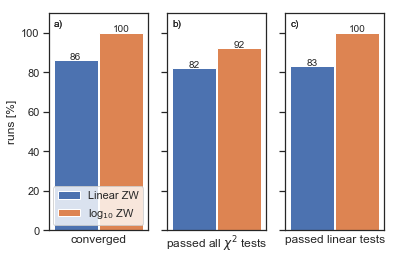

In [27]:
fig, sps = plt.subplots(ncols=3, sharey=True, figsize=(6, 4))

for kk, key in enumerate(resultsOE.keys()):

    converged = len(resultsOE[key].time)
    passedLinearity = (resultsOE[key].trueLinearityChi2 <
                       resultsOE[key].trueLinearityChi2Critical).sum().values
    passedChi2 = (resultsOE[key].chi2value <
                  resultsOE[key].chi2critical).all('chi2test').sum().values

    sps[0].bar(kk, converged, label=key, width=0.98)
    sps[1].bar(kk, passedChi2, label=key, width=0.98)
    sps[2].bar(kk, passedLinearity, label=key, width=0.98)

    sps[0].text(
        kk, converged + .25, str(converged), horizontalalignment='center')
    sps[1].text(
        kk, passedChi2 + .25, str(passedChi2), horizontalalignment='center')
    sps[2].text(
        kk,
        passedLinearity + .25,
        str(passedLinearity),
        horizontalalignment='center')

    sps[0].set_xticks([])
    sps[1].set_xticks([])
    sps[2].set_xticks([])
    sps[0].set_xlabel('converged')
    sps[2].set_xlabel('passed linear tests')
    sps[1].set_xlabel('passed all $\chi^2$ tests')

    sps[0].set_ylabel('runs [%]')
    sps[0].set_ylim(0, 110)
    sps[0].legend(loc='lower center')

    for ii in range(3):
        sps[ii].text(
            0.05,
            0.97,
            '%s)' % (abc[ii]),
            horizontalalignment='left',
            verticalalignment='top',
            transform=sps[ii].transAxes)

Independently how performance is measured, the version with the logarithmic $\mathbf{x}$ variables performs better. It should be noted that applying a $\chi^2$ test with 5% confidence interval to a larger number of retrievals means that 5% of the profiles do not pass the test even though they are fine.

## Compare retrieval error distributions

Similar to the prior, we also compare the distributions of relative retrieval errors defined with

   \begin{equation}
   \frac{\mathbf{x}_{op} - \mathbf{x}_{truth}}{\sqrt{(\textrm{diag}( \mathsf{S}_y)}}
   \end{equation}

In theory, the relative retrieval errors should follow a normal distribution with mean 0 and standard deviation 1. 

Linear ZW Dm 0.07216604018428152 0.7005116962771092
Linear ZW Nw -0.23113348784388427 0.6793344847711055
Linear ZW Smprime 0.012599830155406845 0.8470757360353858
log$_{10}$ ZW Dm_log10 0.05955728835880719 0.8885320534440007
log$_{10}$ ZW Nw_log10 -0.04929724584021764 0.8247280899649884
log$_{10}$ ZW Smprime_log10 0.0687430171621861 0.9947203205079359


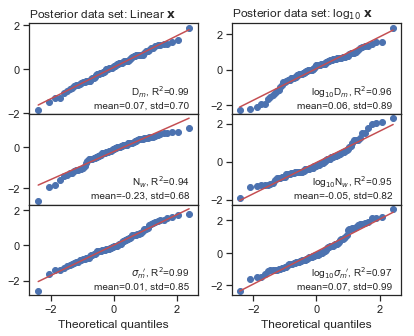

In [28]:
ncols = len(resultsOE.keys())
fig, sps = plt.subplots(
    figsize=(3.33 * ncols, 5), nrows=len(x_vars), ncols=ncols, sharex=True)

sps = sps.reshape((len(x_vars), ncols))

jj = 0

for yy, key in enumerate(resultsOE.keys()):

    for kk in range(3):

        x_var = resultsOE[key].x_vars.values[kk]
        thisOe = resultsOE[key].isel(x_vars=kk)
        passedChiTests = (thisOe.chi2value <=
                          thisOe.chi2critical).all('chi2test')
        thisOe = thisOe.where(passedChiTests).dropna('time')
        x_err = ((thisOe['x_op'] - thisOe['x_truth']) / thisOe['x_op_err'])

        x_mean = x_err.mean().values
        x_std = x_err.std().values

        print(key, x_var, x_mean, x_std)

        (osm, osr), (slope, intercept, r) = stats.probplot(
            x_err, dist="norm", plot=sps[kk, yy], fit=True, rvalue=False)

        sps[kk, yy].set_title('')
        if kk == 0:
            sps[kk, yy].set_title(
                'Posterior data set: %s $\mathbf{x}$' %
                (key.split(' ')[0]),
                loc='left')

        sps[kk, yy].text(
            0.95,
            0.05,
            '%s, R$^2$=%.2f\nmean=%.2f, std=%.2f' %
            (supporting_routines.niceKeys[x_var], r**2, x_mean, x_std),
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=sps[kk, yy].transAxes)

        if kk < 2:
            sps[kk, yy].set_xlabel("")
        sps[kk, yy].set_ylabel("")

        jj += 1

fig.subplots_adjust(hspace=0)

With one exception, mean and standard deviation are closer to 0 and 1, respectively, for the logarithmic retrieval. In other words, non-normally distributed state variables lead to non-normally distributed retrieval error distributions. In this case, the retrieval uncertainty is not correctly described with **S**$_{op}$. 

## Compare retrieval information content

Here, we compare the information content of the two retrieval versions. For this we use the optimal to prior uncertainty ratio (defined as sqrt[diag(**S**$_{op}$)/diag(**S**$_a$)]) and the individual *d* for all profiles

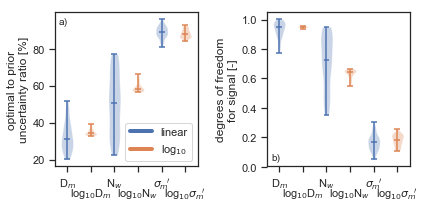

In [29]:

fig, [ax1, ax2] = plt.subplots(ncols = 2, figsize=(6,3))
positions = np.array([0,2,4])
                     


for yy, key in enumerate(resultsOE.keys()):

    thisOE = resultsOE[key].where((resultsOE[key].chi2value < resultsOE[key].chi2critical).all('chi2test'))
    
    dat = (thisOE['x_op_err']/thisOE['x_a_err']).to_pandas().dropna() * 100
    ax1.violinplot(dat.T, positions = positions+yy, showmedians=True)


    dat = (thisOE['dgf_x']).to_pandas().dropna()
    ax2.violinplot(dat.T, positions = positions+yy, showmedians=True)
    
    
cols = ['Dm', 'Dm_log10', 'Nw', 'Nw_log10', 'Smprime', 'Smprime_log10']
labels = []
for tt in cols:
    labels.append(supporting_routines.niceKeys[tt].replace('log','\nlog'))
ax2.set_xticks(range(6)) 
ax2.set_xticklabels(labels) 
ax1.set_xticks(range(6)) 
ax1.set_xticklabels(labels) 

ax1.set_ylabel('optimal to prior\nuncertainty ratio [%]')
ax2.set_ylabel('degrees of freedom\nfor signal [-]')

custom_lines = [matplotlib.lines.Line2D([0], [0], color='C0', lw=4),
                matplotlib.lines.Line2D([0], [0], color='C1', lw=4),
               ]

ax1.legend(custom_lines, ['linear', 'log$_{10}$'], loc='lower right')
ax1.text(0.03, 0.97, 'a)', horizontalalignment='left', verticalalignment='top', transform = ax1.transAxes)
ax2.text(0.03, 0.03, 'b)', horizontalalignment='left', verticalalignment='bottom', transform = ax2.transAxes)

plt.tight_layout()
plt.savefig('Figure4.png', dpi=200)
plt.savefig('Figure4.pdf')


Interestingly, the median values of the optimal to prior uncertainty ratio distribution are lower for the linear state variables indicating that the linear retrieval version is in general underestimating retrieval uncertainties. At the same time, *d* can be greatly overestimated for individual profiles. 

# References

Mech, M., M. Maahn, S. Kneifel, D. Ori, E. Orlandi, P. Kollias, V. Schemann, and S. Crewell, 2020: PAMTRA 1.0: A Passive and Active Microwave radiative TRAnsfer tool for simulating radiometer and radar measurements of the cloudy atmosphere. Geoscientific Model Development Discussions, 1–34, doi:https://doi.org/10.5194/gmd-2019-356.

Testud, J., S. Oury, R. A. Black, P. Amayenc, and X. Dou, 2001: The concept of normalized distribution to describe raindrop spectra: A tool for cloud physics and cloud remote sensing. *J. Appl. Meteorol.*, 40, 1118–1140, [https://doi.org/10.1175/1520-0450(2001)040<1118:TCONDT>2.0.CO;2](https://doi.org/10.1175/1520-0450(2001)040<1118:TCONDT>2.0.CO;2).

Williams, C. R., V. N. Bringi, L. D. Carey, V. Chandrasekar, P. N. Gatlin, Z. S. Haddad, R. Meneghini, S. Joseph Munchak, S. W. Nesbitt, W. A. Petersen, S. Tanelli, A. Tokay, A. Wilson, and D. B. Wolff, 2014: Describing the Shape of Raindrop Size Distributions Using Uncorrelated Raindrop Mass Spectrum Parameters. *J. Appl. Meteor. Climatol.*, 53, 1282–1296, https://doi.org/10.1175/JAMC-D-13-076.1.


